# Inference: Logistic Growth with a Constant and Multiplicative Gaussian Error

This example shows you how to perform Bayesian inference on a time-series problem with a constant and multiplicative Gaussian error, using [Haario's Adaptive Covariance MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_ac_mcmc.html).

A constant and multiplicative Gaussian error is a Gaussian error whose standard deviation receives a constant contribution $\sigma _{\text{base}}$, and a contribution $\sigma _{\text{rel}}$ that scales with the model output. In other words, for a model $f(t; \theta)$ its constant and multiplicative Gaussian error is

\begin{equation*}
    \varepsilon = \left(\sigma _{\text{base}} + \sigma _{\text{rel}} f(t; \theta)^{\eta}\right) \varepsilon _n,
\end{equation*}

where $\eta $ is some constant that controls the relative scaling behaviour of the error. $\varepsilon _n$ is a standard Gaussian random variable, $\varepsilon _n\sim \mathcal{N}(0, 1)$. A constant and multiplicative Gaussian error model for inference may be implemented using `pints.ConstantAndMultiplicativeGaussianLogLikelihood`.

As a toy time-series we consider a logistic Growth

\begin{equation*}
    f(t; \theta) = \frac{k}{1 + (k / f_0 - 1) e^{-r t}},
\end{equation*}

where the model parameters $\theta = (f_0, r, k)$ is the initial population size $f(t=0, \theta) = f_0$, the growth rate $r$ and the carrying capacity $k$. A logistic growth model with a combined Gaussian error

\begin{equation*}
    y(t; \theta, \sigma _{\text{base}}, \eta, \sigma _{\text{rel}}) = f(t; \theta)f(t, \theta) + \left(\sigma _{\text{base}} + \sigma _{\text{rel}} f(t; \theta)^{\eta}\right) \varepsilon _n,
\end{equation*}

has thus 6 model parameters which we may want to learn from data.

## Generating data

To illustrate how Bayesian inference may be used to learn the parameters of a logistic growth model with a linear heteroscedastic Gaussian error, let us generate some data for a fixed set of model parameters

\begin{equation*}
    (f_0, r, k, \sigma _{\text{base}}, \eta, \sigma _{\text{rel}}) = (2, 0.015, 500, 10, 1.1, 0.05).
\end{equation*}

In [1]:
#
# Generate data for a logistic growth with a combined Gaussian error.
#

import numpy as np
import pints.toy


# Define model parameters
parameters = [2, 0.015, 500, 10, 1.1, 0.05]
f_0, r, k, sigma_base, eta, sigma_rel = parameters

# Instantiate logistic growth model with f(t=0) = f_0
model = pints.toy.LogisticModel(initial_population_size=f_0)

# Define measurement time points
times = np.linspace(start=0, stop=1000, num=100)

# Solve logistic growth model
model_output = model.simulate(parameters=[r, k], times=times)

# Add noise to the model output according to the combined Gaussian error model
# Draw a standard Gaussian random variable for each model output
gauss = np.random.normal(loc=0.0, scale=1.0, size=len(model_output))

# Scale standard Gaussian noise according to error model
error = (sigma_base + sigma_rel * model_output**eta) * gauss

# Add noise to model output
observations = model_output + error

# Save data as time-observation tuples
data = np.vstack([times, observations])

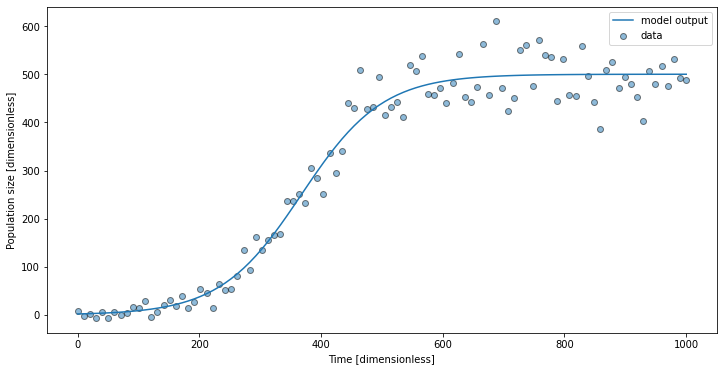

In [2]:
#
# Illustrate data.
#
# This cell needs the above defined data and model output:
# [data, model_output]
#

import matplotlib.pyplot as plt


# Create figure
plt.figure(figsize=(12, 6))

# Plot model output (no noise)
plt.plot(data[0, :], model_output, label='model output')

# Plot generated data
plt.scatter(data[0, :], data[1, :], label='data', edgecolors='black', alpha=0.5)

# Create X and Y axis title
plt.xlabel('Time [dimensionless]')
plt.ylabel('Population size [dimensionless]')

# Create legend
plt.legend()

# Show figure
plt.show()

## Inference of model parameters

We now try to recover the model parameters using 

1. [`pints.HaarioACMC`](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_ac_mcmc.html)
2. [`pints.HamiltonianMCMC`](https://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html).

In order to do that we need to construct a [`pints.LogPosterior`](https://pints.readthedocs.io/en/latest/log_pdfs.html#pints.LogPosterior) that incorporates the above simulated data, the logistic growth model and the error model. For a detailed introduction how to do this in [pints](https://pints.readthedocs.io/en/latest/), please have a look at the dedicated [notebooks](https://github.com/pints-team/pints/blob/master/examples/sampling/first-example.ipynb).

Let us simplify the inference by fixing the initial population size $f_0$ and the carrying capacity $k$ to the true values.

In [3]:
#
# Construct posterior.
#
# Step 1: Wrap logistic growth model in a pints.ForwardModel()
# Step 2: Create a pints.SingleOutputProblem(), combining the data and the wrapped logostic growth model.
# Step 3: Create a pints.LinearHeteroscedasticGaussianLogLikelihood() from the pints.SingleOutputProblem()
# Step 4: Define pints.LogPrior() for the model parameters.
# Step 5: Combine priors and likelihood to create a pints.LogPosterior().
#
# This cell needs the above defined true parameters, and the generated data:
# [parameters, data]
#

import numpy as np
import pints
import pints.toy


# Get true initial population size and carrying capacity
f_0 = parameters[0]
k = parameters[2]

# Forget about f_0 and k (we won't infer those parameters)
true_parameters = np.hstack([parameters[1:2], parameters[3:]])

# Create a wrapper around the logistic model
class Model(pints.ForwardModel):
    def __init__(self, f_0, k):
        self._k = k
        self._model = pints.toy.LogisticModel(initial_population_size=f_0)
    def simulate(self, parameters, times):
        return self._model.simulate(parameters=[parameters[0], self._k], times=times)
    def simulateS1(self, parameters, times):
        # Compute model output and gradients w.r.t. r and k
        values, gradient = self._model.simulateS1(parameters=[parameters[0], self._k], times=times)

        # Get gradient w.r.t. r
        gradient = gradient[:, 0]

        return values, gradient
    def n_parameters(self):
        return 1

# Create an inverse problem which links the logistic growth model to the data
problem = pints.SingleOutputProblem(model=Model(f_0=f_0, k=k), times=data[0, :], values=data[1, :])

# Create the combined Gaussian error log-likelihood
log_likelihood = pints.LinearHeteroscedasticGaussianLogLikelihood(problem)

# Create uniform priors for [r, sigma_base, eta, sigma_rel]
log_prior_r = pints.UniformLogPrior(
    [0.005],
    [0.02]
)
log_prior_sigma_base = pints.UniformLogPrior(
    [1],
    [20]
)
log_prior_eta = pints.UniformLogPrior(
    [0.5],
    [1.5]
)
log_prior_sigma_rel = pints.UniformLogPrior(
    [0.001],
    [1]
)
log_prior = pints.ComposedLogPrior(
    log_prior_r, log_prior_sigma_base, log_prior_eta, log_prior_sigma_rel)

# Create posterior
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

### 1. Infer parameters with Haario Adaptive Covariance MCMC

In [4]:
#
# Infer model parameters with Haario ACMC.
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log_posterior]
#

# Choose starting points for mcmc chains
xs = [
    true_parameters * 1.01,
    true_parameters * 0.9,
    true_parameters * 1.15,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HaarioACMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
hacmc_chains = mcmc.run()
print('Done!')

Running...
Using Haario adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0          0:00.0
100   303    0         0.0396    0.0198     0:00.1
Initial phase completed.
200   603    0.00498   0.0249    0.00995    0:00.2
300   903    0.192691  0.166113  0.14       0:00.2
400   1203   0.214     0.18      0.175      0:00.3
500   1503   0.206     0.188     0.166      0:00.4
600   1803   0.201     0.191     0.161      0:00.5
700   2103   0.191     0.189729  0.17       0:00.6
800   2403   0.195     0.189     0.166      0:00.7
900   2703   0.201     0.196     0.176      0:00.8
1000  3003   0.196     0.194     0.178      0:00.9
1100  3303   0.193     0.191     0.176      0:01.0
1200  3603   0.195     0.192     0.176      0:01.1
1300  3903

param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
r           0.02    0.00    0.01    0.01   0.02   0.02   0.02     1.00    1306.42  177.23
sigma_base  7.24    1.99    3.97    5.80   7.02   8.52   11.70    1.03    204.07   27.68
eta         0.72    0.12    0.59    0.64   0.68   0.75   1.12     1.05    46.75    6.34
sigma_rel   0.59    0.26    0.04    0.40   0.62   0.82   0.98     1.03    74.36    10.09


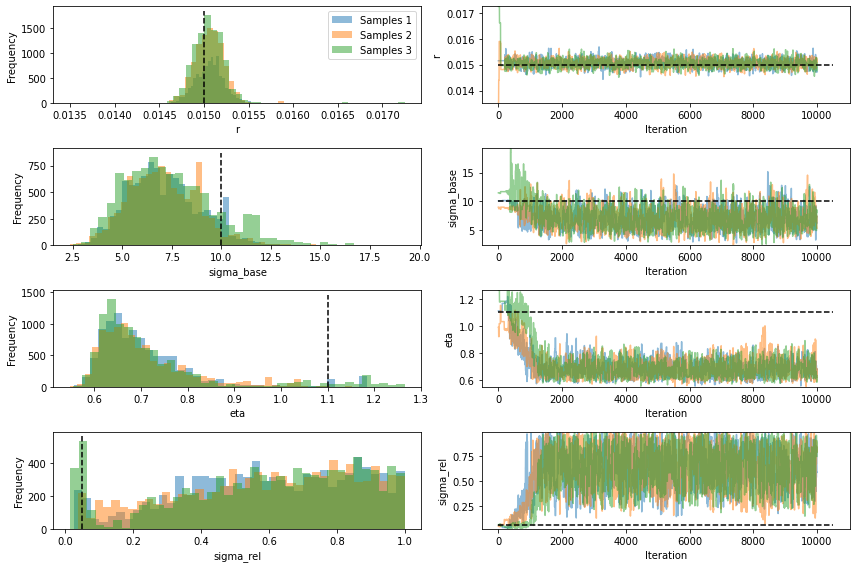

In [5]:
#
# Compute diagnostics and show diagnostic plots.
#
# This cell needs the HaarioACMC chains:
# [hacmc_chains]
#

import pints
import pints.plot


# Show diagnostics summary
results = pints.MCMCSummary(chains=hacmc_chains, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(samples=hacmc_chains, parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'], ref_parameters=true_parameters)
plt.show()

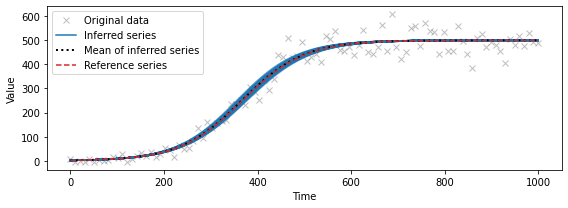

In [6]:
# Show predicted time series for the first chain
pints.plot.series(hacmc_chains[0, 200:], problem, true_parameters)
plt.show()

### 2. Infer parameters with Hamiltonian MCMC

In [7]:
#
# Infer model parameters with Hamiltonian MCMC.
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log_posterior]
#

# Choose starting points for mcmc chains
xs = [
    true_parameters * 1.01,
    true_parameters * 0.98,
    true_parameters * 1.03,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Set step size
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.0001, 0.5, 0.05, 0.05])

# Run!
print('Running...')
hmcmc_chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0         0          0:00.0
2     123    0.5       0.25      0.25       0:00.1
3     183    0.6       0.4       0.4        0:00.1
100   6003   0.941     0.961     0.951      0:02.1
200   12003  0.931     0.975     0.965      0:04.1
300   18003  0.94      0.977     0.934      0:06.2
400   24003  0.920398  0.983     0.943      0:08.5
500   30003  0.926     0.984     0.928      0:10.7
600   36003  0.939     0.985     0.925      0:12.8
700   42003  0.923     0.974359  0.923      0:14.8
800   48003  0.914     0.976     0.931      0:16.8
900   54003  0.918     0.976     0.937      0:18.8
1000  60003  0.916     0.971     0.939      0:20.9
1100  66003  0.922     0.972     0.942      0:23.0
1200  72003  0.922629  0.968386  0.943      0:25.0
1300  78003  0.925     0.966     0.945     

param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
r           0.02    0.00    0.01    0.01   0.02   0.02   0.02     1.00    1361.62  32.55
sigma_base  7.28    2.00    3.87    5.82   7.10   8.58   11.72    1.00    238.02   5.69
eta         0.71    0.10    0.59    0.64   0.69   0.76   0.96     1.01    201.66   4.82
sigma_rel   0.59    0.26    0.11    0.39   0.60   0.81   0.98     1.01    181.70   4.34


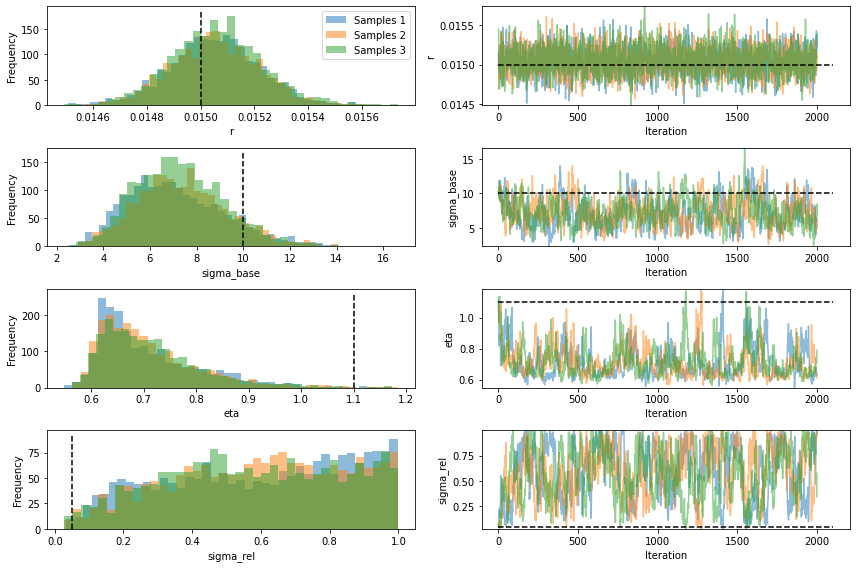

In [8]:
#
# Compute diagnostics and show diagnostic plots.
#
# This cell needs the HamiltonianMCMC chains:
# [hmcmc_chains]
#

import pints
import pints.plot


# Show diagnostics summary
results = pints.MCMCSummary(chains=hmcmc_chains, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(samples=hmcmc_chains, parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'], ref_parameters=true_parameters)
plt.show()

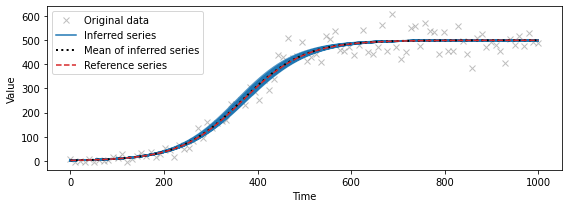

In [9]:
# Show predicted time series for the first chain
pints.plot.series(hmcmc_chains[0, 200:], problem, true_parameters)
plt.show()

## Fix noise parameter $\eta $

It appears as if the data is not rich enough to infer all 3 noise parameters $(\sigma _{\text{base}}, \eta, \sigma _{\text{rel}})$. Let us therefore fix $\eta $ at the data generating value and run the inference again.

In [10]:
#
# Define wrapper for log_posterior that fixes eta.
#

import pints


class LogPosteriorWrapper(pints.LogPDF):
    def __init__(self, log_pdf, eta):
        self._log_pdf = log_pdf
        self._eta = eta

    def __call__(self, parameters):
        # Create parameter container
        params = np.empty(shape=len(parameters)+1)

        # Fill container with parameters
        # (This solution is specific to the above presented problem)
        params[:2] = np.asarray(parameters[:2])
        params[2] = self._eta
        params[3] = parameters[2]

        return self._log_pdf(params)

    def evaluateS1(self, parameters):
        # Create parameter container
        params = np.empty(shape=len(parameters)+1)

        # Fill container with parameters
        # (This solution is specific to the above presented problem)
        params[:2] = np.asarray(parameters[:2])
        params[2] = self._eta
        params[3] = parameters[2]

        # Compute posterior and partials 
        L, dL = self._log_pdf.evaluateS1(params)

        # Create mask for relevant partials
        mask = np.ones(shape=len(parameters)+1, dtype=bool)
        mask[2] = False

        return L, dL[mask]

    def n_parameters(self):
        return self._log_pdf.n_parameters() - 1


In [11]:
#
# Construct posterior.
#
# Step 1: Wrap logistic growth model in a pints.ForwardModel()
# Step 2: Create a pints.SingleOutputProblem(), combining the data and the wrapped logostic growth model.
# Step 3: Create a pints.CombinedGaussianLogLikelihood() from the pints.SingleOutputProblem()
# Step 4: Define pints.LogPrior() for the model parameters.
# Step 5: Combine priors and likelihood to create a pints.LogPosterior().
#
# This cell needs the above defined true parameters, the generated data, and the model wrapper to be able to fix eta:
# [parameters, data, LogPosteriorWrapper]
#

import numpy as np
import pints
import pints.toy


# Get true initial population size and carrying capacity
f_0 = parameters[0]
k = parameters[2]

# Forget about f_0 and k (we won't infer those parameters)
true_parameters = np.hstack([parameters[1:2], parameters[3:]])

# Create a wrapper around the logistic model
class Model(pints.ForwardModel):
    def __init__(self, f_0, k):
        self._k = k
        self._model = pints.toy.LogisticModel(initial_population_size=f_0)
    def simulate(self, parameters, times):
        return self._model.simulate(parameters=[parameters[0], self._k], times=times)
    def simulateS1(self, parameters, times):
        # Compute model output and gradients w.r.t. r and k
        values, gradient = self._model.simulateS1(parameters=[parameters[0], self._k], times=times)

        # Get gradient w.r.t. r
        gradient = gradient[:, 0]

        return values, gradient
    def n_parameters(self):
        return 1

# Create an inverse problem which links the logistic growth model to the data
problem = pints.SingleOutputProblem(model=Model(f_0=f_0, k=k), times=data[0, :], values=data[1, :])

# Create the combined Gaussian error log-likelihood
log_likelihood = pints.LinearHeteroscedasticGaussianLogLikelihood(problem)

# Create uniform priors for [r, sigma_base, eta, sigma_rel]
log_prior_r = pints.UniformLogPrior(
    [0.005],
    [0.02]
)
log_prior_sigma_base = pints.UniformLogPrior(
    [1],
    [20]
)
log_prior_eta = pints.UniformLogPrior(
    [0.5],
    [1.5]
)
log_prior_sigma_rel = pints.UniformLogPrior(
    [0.001],
    [1]
)
log_prior = pints.ComposedLogPrior(
    log_prior_r, log_prior_sigma_base, log_prior_eta, log_prior_sigma_rel)

# Create posterior (free eta)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Fix eta
eta = true_parameters[2]
log_posterior_fixed_eta = LogPosteriorWrapper(log_posterior, eta)

In [12]:
#
# Infer model parameters with Haario ACMC.
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log_posterior_fixed_eta]
#

# Extract unfixed parameters from true parameters
true_parameters_fixed_eta = np.empty(shape=len(true_parameters)-1)
true_parameters_fixed_eta[0:2] = true_parameters[0:2]
true_parameters_fixed_eta[2] = true_parameters[3]

# Choose starting points for mcmc chains
xs = [
    true_parameters_fixed_eta * 1.01,
    true_parameters_fixed_eta * 0.9,
    true_parameters_fixed_eta * 1.15,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior_fixed_eta, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HaarioACMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
hacmc_chains_fixed_eta = mcmc.run()
print('Done!')

Running...
Using Haario adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0.5        0:00.0
2     9      0         0.333     0.333      0:00.0
3     12     0         0.25      0.25       0:00.0
100   303    0         0.0297    0.0396     0:00.1
Initial phase completed.
200   603    0         0.0149    0.0199     0:00.2
300   903    0.15      0.179402  0.163      0:00.2
400   1203   0.177     0.204     0.19202    0:00.3
500   1503   0.184     0.21      0.198      0:00.4
600   1803   0.185     0.205     0.202995   0:00.5
700   2103   0.192582  0.201     0.197      0:00.5
800   2403   0.196005  0.202     0.201      0:00.6
900   2703   0.202     0.203     0.204      0:00.7
1000  3003   0.208     0.204     0.201      0:00.8
1100  3303   0.207     0.198     0.201      0:00.9
1200  3603   0.206     0.2       0.208      0:01.0
1300  3903

param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
r           0.02    0.00    0.01    0.01   0.02   0.02   0.02     1.00    2116.83  269.54
sigma_base  10.83   1.91    7.83    9.43   10.59  11.94  15.20    1.00    1570.93  200.03
sigma_rel   0.04    0.01    0.03    0.04   0.04   0.05   0.06     1.00    1577.74  200.90


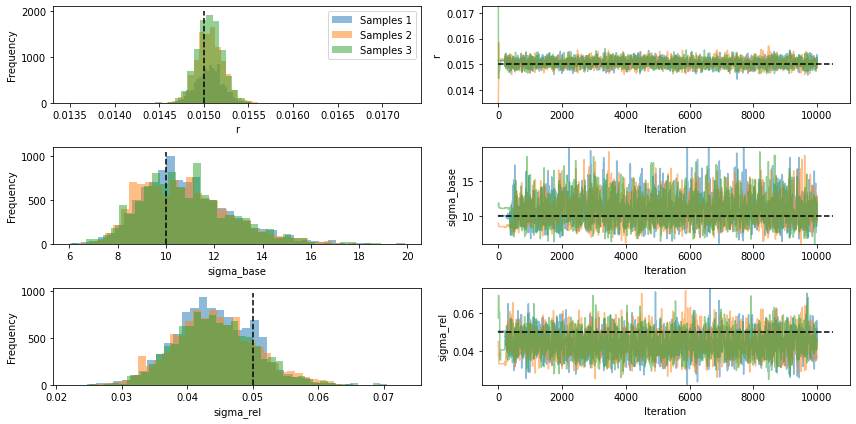

In [13]:
#
# Compute diagnostics and show diagnostic plots.
#
# This cell needs the HaarioACMC chains:
# [hacmc_chains_fixed_eta]
#

import pints
import pints.plot


# Show diagnostics summary
results = pints.MCMCSummary(chains=hacmc_chains_fixed_eta, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(samples=hacmc_chains_fixed_eta, parameter_names=['r', 'sigma_base', 'sigma_rel'], ref_parameters=true_parameters_fixed_eta)
plt.show()

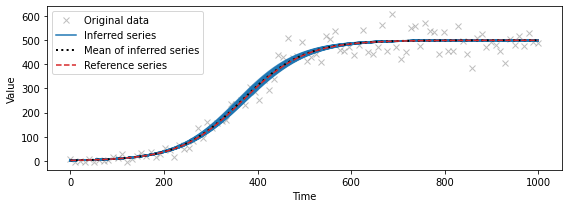

In [14]:
# Show predicted time series for the first chain
pints.plot.series(hacmc_chains_fixed_eta[0, 200:], problem, true_parameters_fixed_eta)
plt.show()

In [15]:
#
# Infer model parameters with Hamiltonian MCMC.
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log_posterior_fixed_eta]
#

# Extract unfixed parameters from true parameters
true_parameters_fixed_eta = np.empty(shape=len(true_parameters)-1)
true_parameters_fixed_eta[0:2] = true_parameters[0:2]
true_parameters_fixed_eta[2] = true_parameters[3]

# Choose starting points for mcmc chains
xs = [
    true_parameters_fixed_eta * 1.01,
    true_parameters_fixed_eta * 0.9,
    true_parameters_fixed_eta * 1.15,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior_fixed_eta, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Set step size
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.0001, 0.5, 0.05])

# Run!
print('Running...')
hmcmc_chains_fixed_eta = mcmc.run()
print('Done!')

Running...
Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0.333     0.333      0:00.0
2     123    0.5       0.25      0.5        0:00.1
3     183    0.6       0.4       0.6        0:00.1
100   6003   0.863     0.833     0.843      0:02.3
200   12003  0.866     0.866     0.871      0:04.7
300   18003  0.868     0.868     0.884106   0:06.9
400   24003  0.878     0.886     0.883      0:09.2
500   30003  0.89      0.884     0.884      0:11.7
600   36003  0.894     0.884     0.887      0:13.9
700   42003  0.897     0.885     0.879      0:16.0
800   48003  0.894015  0.888     0.882793   0:18.2
900   54003  0.889     0.88      0.888      0:20.1
1000  60003  0.894     0.882     0.891      0:22.0
1100  66003  0.892922  0.882     0.892922   0:24.0
1200  72003  0.893     0.883     0.892      0:25.9
1300  78003  0.895     0.882     0.895     

param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
r           0.02    0.00    0.01    0.01   0.02   0.02   0.02     1.00    1204.75  28.55
sigma_base  10.96   1.96    7.68    9.53   10.77  12.14  15.36    1.01    288.49   6.84
sigma_rel   0.04    0.01    0.03    0.04   0.04   0.05   0.06     1.00    679.91   16.11


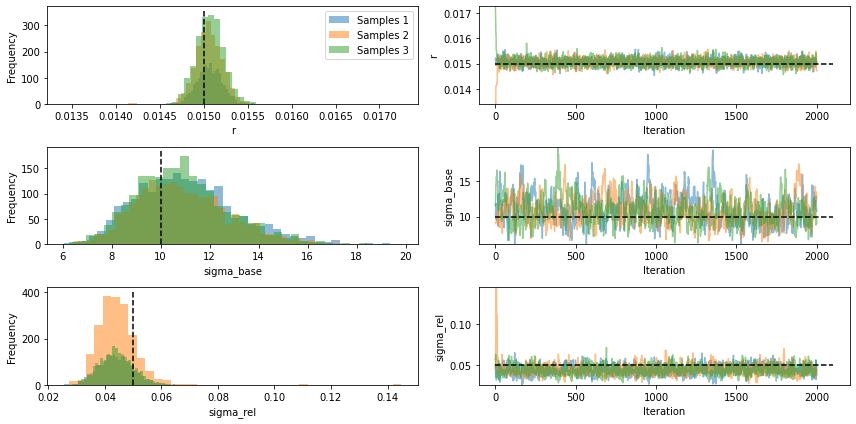

In [16]:
#
# Compute diagnostics and show diagnostic plots.
#
# This cell needs the HamiltonianMCMC chains:
# [hmcmc_chains_fixed_eta]
#

import pints
import pints.plot


# Show diagnostics summary
results = pints.MCMCSummary(chains=hmcmc_chains_fixed_eta, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(samples=hmcmc_chains_fixed_eta, parameter_names=['r', 'sigma_base', 'sigma_rel'], ref_parameters=true_parameters_fixed_eta)
plt.show()

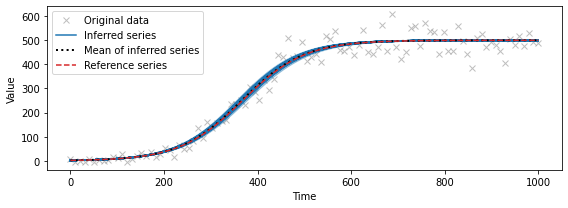

In [17]:
# Show predicted time series for the first chain
pints.plot.series(hmcmc_chains_fixed_eta[0, 200:], problem, true_parameters_fixed_eta)
plt.show()